In [50]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [51]:
path = "seed_1234_sample_rate_10_lr_0.01_n_epochs_200_hidden_dim_2_log.pkl"

with open(path, 'rb') as file:
    log_hist = pickle.load(file)

In [52]:
log_hist.keys()


dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_failures', 'patience_hist'])

In [53]:
log_hist['stopping_criteria']

'max-epochs'

In [54]:
pat = log_hist['patience_hist']

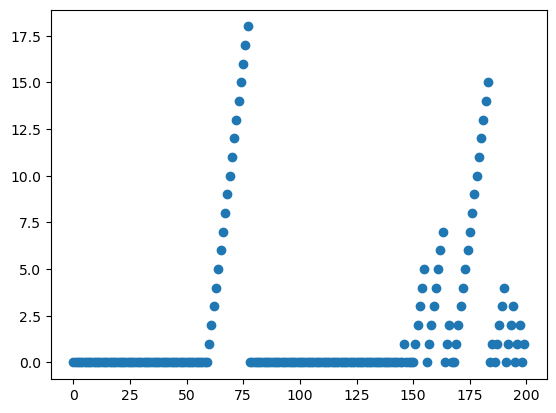

In [55]:
plt.scatter(np.arange(len(pat)), pat)
plt.show()

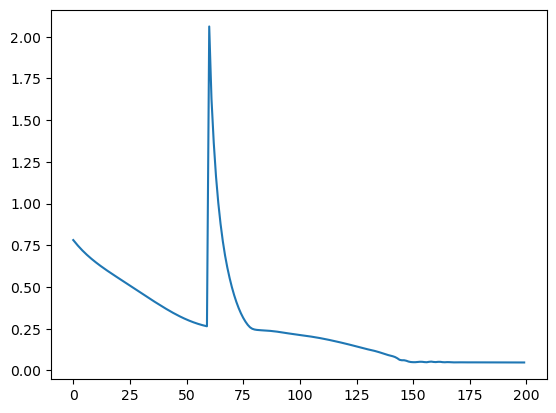

In [56]:
plt.plot(log_hist['losses'])

In [57]:
log_hist["losses"][-10:]

[0.04811543598771095,
 0.04805716499686241,
 0.04800398647785187,
 0.04797166958451271,
 0.047958794981241226,
 0.04794561490416527,
 0.047914210706949234,
 0.047867704182863235,
 0.047824401408433914,
 0.04779605567455292]

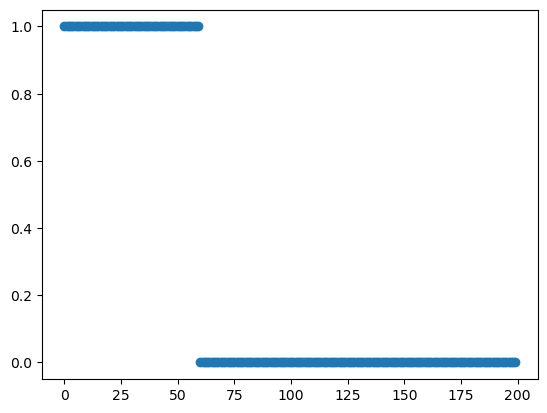

In [58]:
fail = log_hist['method_failures']
plt.scatter(np.arange(len(fail)), fail)

In [59]:
path= "seed_1234_sample_rate_5_lr_0.01_n_epochs_200_hidden_dim_2_log.pkl"

In [60]:
path = "seed_1234_sample_rate_5_lr_0.01_n_epochs_200_hidden_dim_2_log.pkl"

with open(path, 'rb') as file:
    log_hist2 = pickle.load(file)

In [61]:
log_hist2["stopping_criteria"]

'max-epochs'

In [62]:
pat = log_hist2['patience_hist']

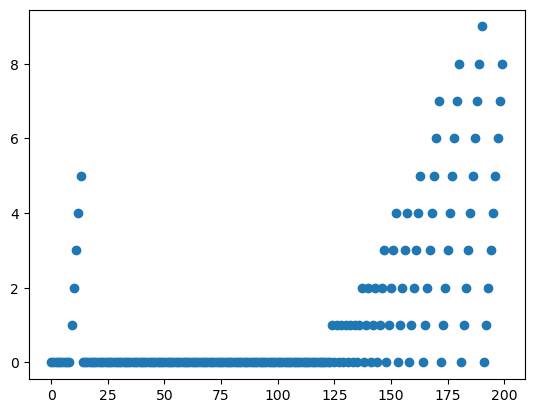

In [63]:
plt.scatter(np.arange(len(pat)), pat)
plt.show()

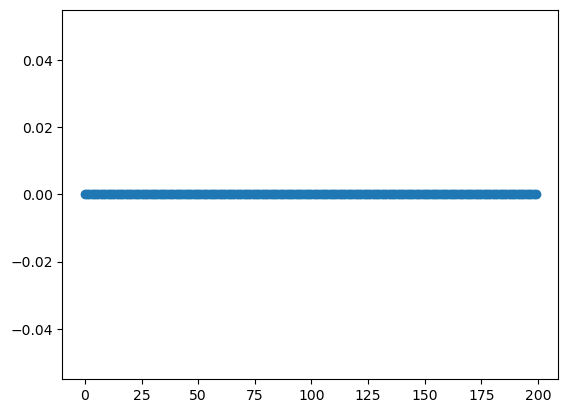

In [64]:
fail = log_hist2['method_failures']
plt.scatter(np.arange(len(fail)), fail)

In [65]:
np.sum(log_hist2['times']) / 60 

2.5476610541343687

In [66]:
log_hist2['losses'][-20:], len(log_hist2['losses'])

([0.23644399642944336,
  0.23643256723880768,
  0.23642125725746155,
  0.23641006648540497,
  0.23639896512031555,
  0.2363879531621933,
  0.2363770455121994,
  0.23636621236801147,
  0.23635543882846832,
  0.23634472489356995,
  0.23633407056331635,
  0.23632347583770752,
  0.23631298542022705,
  0.236302450299263,
  0.2362920045852661,
  0.236281618475914,
  0.2362712323665619,
  0.23626087605953217,
  0.23625054955482483,
  0.23624026775360107],
 200)

In [67]:
path = "seed_1234_sample_rate_1_lr_0.01_n_epochs_200_hidden_dim_2_log.pkl"


with open(path, 'rb') as file:
    log_hist3 = pickle.load(file)

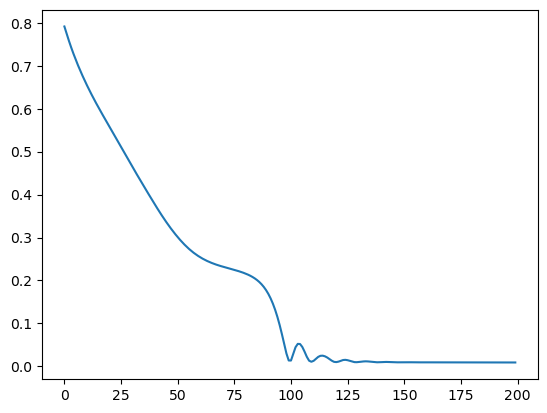

In [68]:
plt.plot(log_hist3['losses'])

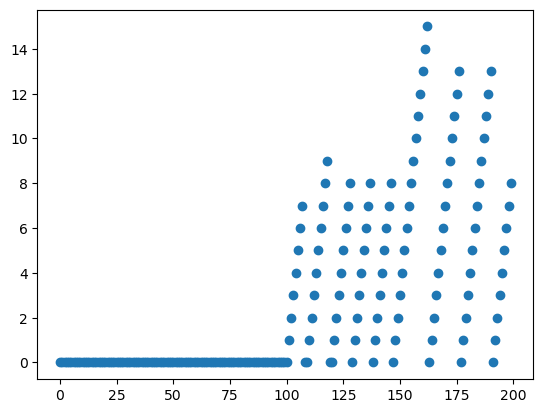

In [69]:
pat = log_hist3['patience_hist']
plt.scatter(np.arange(len(pat)), pat)
plt.show()

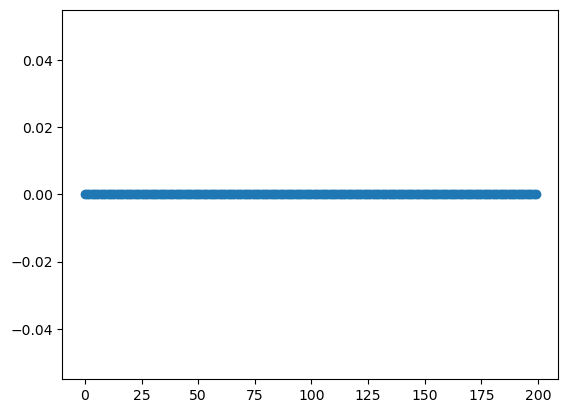

In [70]:
fail = log_hist3['method_failures']
plt.scatter(np.arange(len(fail)), fail)

In [71]:
log_hist3['losses'][-20:]

[0.009216818027198315,
 0.009206621907651424,
 0.009201277047395706,
 0.009198731742799282,
 0.009196140803396702,
 0.009192299097776413,
 0.009185676462948322,
 0.009176996536552906,
 0.009168337099254131,
 0.009160558693110943,
 0.009154644794762135,
 0.00915049109607935,
 0.009146648459136486,
 0.009142424911260605,
 0.009137221612036228,
 0.009130916558206081,
 0.009124452248215675,
 0.009118365123867989,
 0.009113001637160778,
 0.009108524769544601]

In [72]:
from stabnode.node import set_global_seed, _load_model_opt
from data.hysteresis import simulate_steady_state
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
device

'cpu'

In [73]:
# Load data in the same way 
def load_data(seed, sample_rate):
    set_global_seed(seed = seed)
    
    lam_start = -1 
    lam_end = 1
    
    n_points = 250
    
    lam_increase = np.linspace(lam_start,lam_end, n_points)
    lam_decrease = np.linspace(lam_end, lam_start, n_points)
    
    x0=-1
    
    simulate_time = (0.,50.)
    
    x_increase = simulate_steady_state(lam_increase, x0, simulate_time,show_progress=True)
    x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time, show_progress=True)
    
    X = np.hstack((x_increase, x_decrease))
    lam = np.hstack((lam_increase, lam_decrease))
    repeat = 2
    
    for _ in range(repeat):
        X = np.hstack((X,X))
        lam = np.hstack((lam, lam))
    
    tau = torch.arange(0,len(lam),device=device)
    t = (tau+1)*simulate_time[-1]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = scaler.fit_transform(X.reshape(-1,1))
    X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
    
    # sample_rate = 10
    tau_train = tau[::sample_rate]
    X_train = X_scaled[tau_train]
    lam_train = lam[tau_train]

    def lam_func(tau):
        idx = int(tau) % len(lam)
        return torch.tensor(lam[idx],dtype=torch.float32, device=device)
    
    return X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func

## Patience = 50 is included! Just forgot to make name changes in `train_model.py`

In [74]:
model_paths = [
    "seed_1234_sample_rate_1_lr_0.01_n_epochs_200_hidden_dim_2.pt",
    "seed_1234_sample_rate_5_lr_0.01_n_epochs_200_hidden_dim_2.pt",
    "seed_1234_sample_rate_10_lr_0.01_n_epochs_200_hidden_dim_2.pt"
]

In [75]:

seeds = [1234,1234,1234]
sample_rates = [1,5,10]
lrs = [0.01,0.01, 0.01]

In [76]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [77]:
def evaluate_model(model, X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func):
    g = model.g
    f = model.f
    
    g.eval()
    f.eval()
    
    g_true_out = []
    g_pred_out = []
    
    f_true_out = []
    f_pred_out = []
    
    for tau_i in tau:
    
        lam_i = lam_func(tau_i).reshape(-1,1)
        xi = X_scaled[tau_i].reshape(-1,1)
        xi_unscaled = X[tau_i].reshape(-1,1)
    
        g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
        f_true_out.append(f_true(xi_unscaled))
    
        with torch.no_grad():
            g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
            f_pred_out.append(f(xi).detach().cpu().numpy())
    
    g_true_out = np.array(g_true_out).reshape(-1)
    g_pred_out = np.array(g_pred_out).reshape(-1)
    
    f_true_out = np.array(f_true_out).reshape(-1)
    f_pred_out = np.array(f_pred_out).reshape(-1)
    
    finite_idx = np.isfinite(g_true_out)
    np.count_nonzero(~finite_idx)
    g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)
    
    L2_rel_err = np.linalg.norm(g_true_scaled - g_pred_out) / np.linalg.norm(g_true_scaled)

    return g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err
    


In [78]:
true = []
pred = []
tau = []
train = []
l2 = []

for path, seed, sample_rate in zip(model_paths,seeds, sample_rates):
    model, opt, epoch, loss = _load_model_opt(path)
    g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err= evaluate_model(model, *load_data(seed=seed,sample_rate=sample_rate))
    true.append(g_true_scaled)
    pred.append(g_pred_out)
    tau.append(tau_train)
    train.append(X_train)
    l2.append(L2_rel_err)
    
    

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

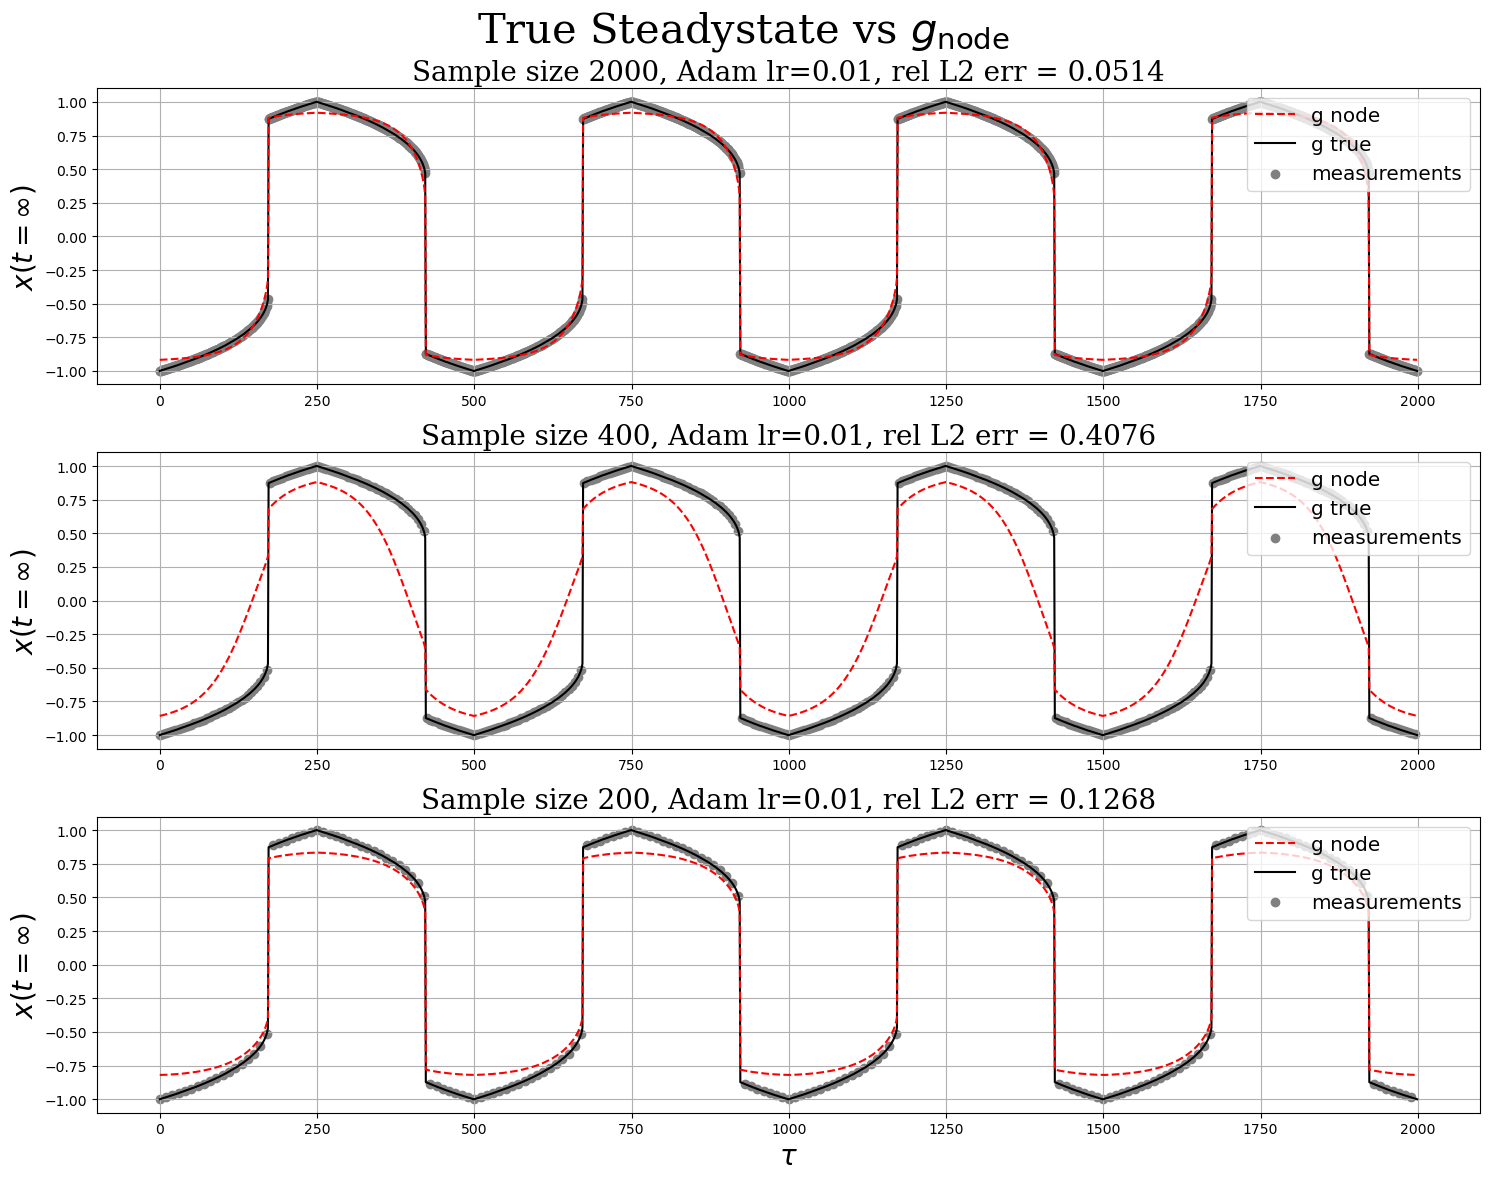

In [79]:
fig, ax  = plt.subplots(3,1,figsize = (15,12))
for idx in range(3):
    ax[idx].plot(pred[idx], linestyle='--', c='red',label='g node', zorder = 5)
    ax[idx].plot(true[idx], label='g true', c='black')
    ax[idx].scatter(tau[idx], train[idx], c='grey', marker='o', label='measurements')
    # plt.plot(X_scaled, label='raw data')
    ax[idx].legend(loc='upper right',fontsize='x-large')
    ax[idx].grid(True)
    ax[idx].set_ylabel(r"$x(t=\infty)$",size=20)
    if idx == 2:
        ax[idx].set_xlabel(r"$\tau$", size=20)
    ax[idx].set_title(f"Sample size {2000//sample_rates[idx]}, Adam lr={lrs[idx]}, rel L2 err = {l2[idx]:.4f}", family='serif',size=20)
plt.suptitle(r"True Steadystate vs $g_{\text{node}}$ ",family='serif', size=30)
plt.tight_layout()
plt.savefig("steady_state_vs_gnode.png")
plt.show()

# Plot control, $\lambda$, as a function of $\tau$

In [80]:
X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func = load_data(seed=1234,sample_rate=5)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

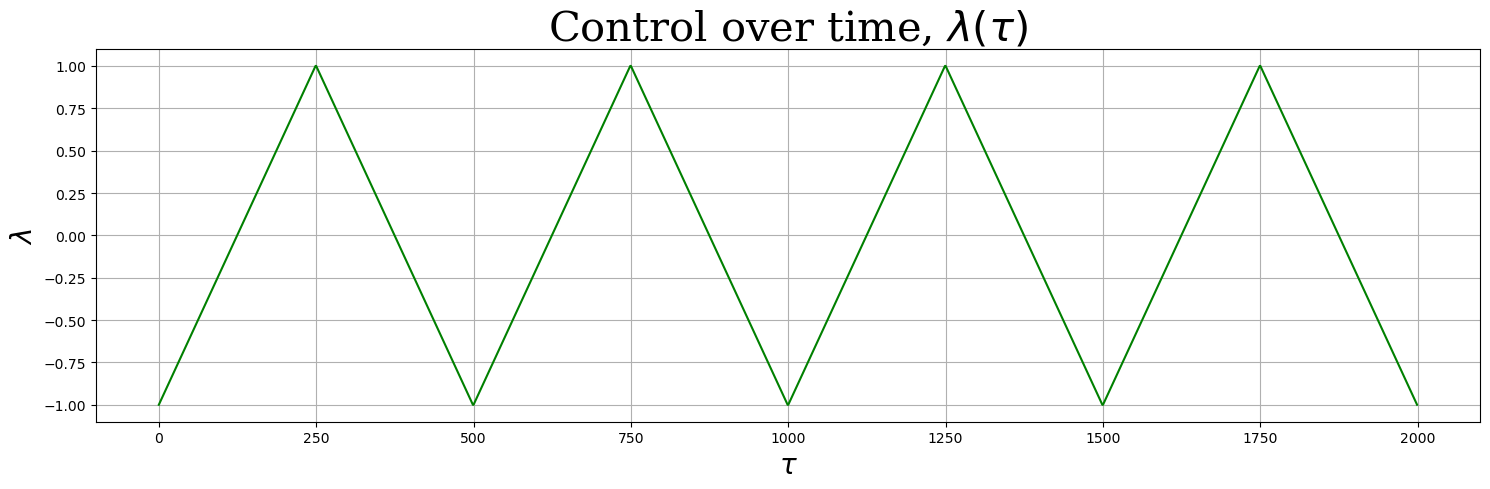

In [81]:
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(tau.numpy(), lam, c='green')
ax.set_xlabel(r"$\tau$", size=20)
ax.set_ylabel(r"$\lambda$", size=20)
ax.grid(True)
ax.set_title(r"Control over time, $\lambda(\tau)$", family = 'serif', size = 30)
plt.tight_layout()
plt.savefig("control.png")
plt.show()